# Network evolution according to closed-cell Stratocumulus network dynamics

This notebook evolves an initial network by repeated application of the network dynamics modeling the evolution of closed-cell Stratocumulus networks. It corresponds to Table 1 and Figure 4 (d, h) of Glassmeier & Feingold (2017).

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys, pickle
import random as rand
import pyvoro as pv
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (4, 4)
mpl.rcParams['agg.path.chunksize'] = 10000
if '..' not in sys.path: sys.path.append('..')
import trafo
import vroni
import scar

In [2]:
PERIODIC = True
XMAX = YMAX = 800

## Initial network

Create an initial network using cell centers from a large-eddy simulation of Stratocumulus cloud cells.

In [3]:
%%time
# load coordinates of cell centers from file
centers = pickle.load(open('cell_centers_IC.p', 'rb'))

# perform Voronoi tesselation based on cell centers
vor = pv.compute_2d_voronoi(centers, [[0, XMAX], [0, YMAX]], max(XMAX, YMAX), periodic=[PERIODIC, PERIODIC])

# convert Voronoi tesselation into cellular network data structure
G = trafo.create_graph_from_vor(vor, periodic=PERIODIC, xmin=0, xmax=XMAX, ymin=0, ymax=YMAX)

CPU times: user 37.8 s, sys: 229 ms, total: 38 s
Wall time: 38.1 s


Inspect the initial network.

Name: 
Type: Graph
Number of nodes: 1100
Number of edges: 3300
Average degree:   6.0000


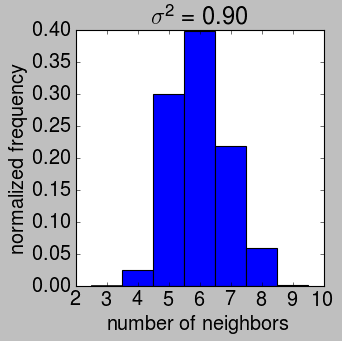

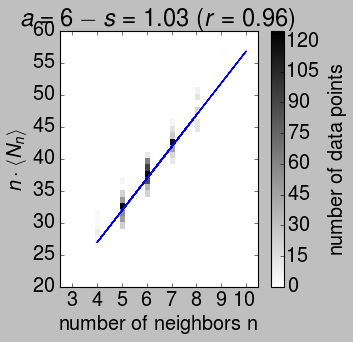

In [4]:
# basic information on initial cellular network
print nx.info(G)

# degree/sidedness histogram of initial cellular network
vroni.plot_degree_hist_from_deglist(vroni.get_degrees(G), title = True)

# Aboav-Weaire plot of initial cellular network
vroni.plot_individual_aw(vroni.aboav_weaire(vroni.nx_nneighbors_of_neighbors(G)))

## Open-cell Stratocumulus

Repeatedly apply open-cell Stratocumulus network dynamics and store topological scars (degree differences).

In [5]:
%%time
G = trafo.create_graph_from_vor(vor, periodic=PERIODIC, xmin=0, xmax=XMAX, ymin=0, ymax=YMAX)
nstep = 10 # number of iterations
nout = 5   # n>nout is considered for the analysis

# lists to store degrees and information for Aboav-Weaire law
degs = []
aws = []

# graph and lists to determine topological scars
Gmid = G.copy()
small_deltas = [] # smaller of the two deltas
large_deltas = [] # larger of the two deltas

rand.seed(531)
for n in range(nstep):
        
    Gold = Gmid.copy()
    Gmid = trafo.evolve_open_cloud_cell(G)
    
    if n > nout:
        for x in vroni.get_degrees(G):
            degs.append(x)
        aws += vroni.nx_nneighbors_of_neighbors(G)
        
        ss, ls = scar.degree_difference_stat(scar.degree_difference_graph(G, Gold))
        for s in ss: small_deltas += [s]
        for l in ls: large_deltas += [l]

CPU times: user 50.7 s, sys: 429 ms, total: 51.2 s
Wall time: 52 s


Inspect the resulting network.

Name: 
Type: Graph
Number of nodes: 1100
Number of edges: 3300
Average degree:   6.0000


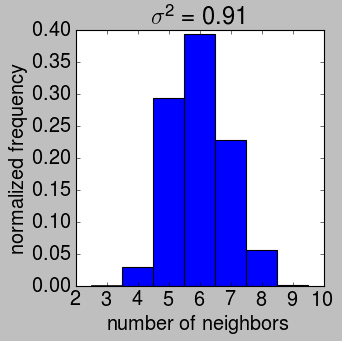

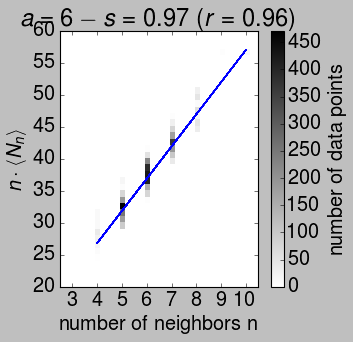

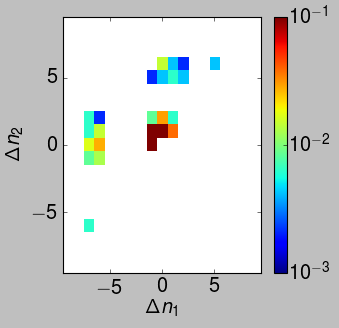

In [6]:
print nx.info(G)
vroni.plot_degree_hist_from_deglist(degs, title = True)
vroni.plot_individual_aw(vroni.aboav_weaire(aws))

# histogram of topological scars
scar.plot_degree_difference_histogram(small_deltas, large_deltas, log=True)